## Analyze A/B Test Results


This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
(df[df.converted == 1].shape[0] / df.shape[0])*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
treat = df.query('group != "treatment" and landing_page == "new_page"').count()[0]
cont = df.query('group != "control" and landing_page == "old_page"').count()[0]
treat + cont

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().all()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
rep_id = df2[df2.user_id.duplicated()].user_id
rep_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates('user_id')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2[df2.converted == 1].shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control = df2[df2.group == 'control']
p_cont_conv = control[control.converted == 1].shape[0]/control.shape[0]
p_cont_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment = df2[df2.group == 'treatment']
p_tret_conv = treatment[treatment.converted == 1].shape[0]/treatment.shape[0]
p_tret_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2[df2.landing_page == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

In [18]:
(p_cont_conv - p_tret_conv)*100

0.15782389853555567

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There's no sufficient evidence that a person would convert to the new page.** 

The treatment group showed that a decrease in the amount of conversions by 0.15%, unlike the control group that showed an increase 0.15% of conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}: p_{new} - p_{old} <= 0$**

**$H_{1}: p_{new} - p_{old} > 0$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df2.landing_page == 'new_page'].converted
n_new.count()

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2.landing_page == 'old_page'].converted
n_old.count()

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.normal(n_new.mean(),n_new.std(),n_new.count())
new_page_converted.mean()

0.11924439121686226

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.normal(n_old.mean(),n_old.std(),n_old.count())
old_page_converted.mean()

0.12097198253828097

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diff

-0.0015782389853555567

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

(array([  16.,  100.,  597., 1711., 2856., 2702., 1505.,  432.,   76.,
           5.]),
 array([-4.51715764e-03, -3.59486692e-03, -2.67257619e-03, -1.75028547e-03,
        -8.27994743e-04,  9.42959813e-05,  1.01658671e-03,  1.93887743e-03,
         2.86116815e-03,  3.78345888e-03,  4.70574960e-03]),
 <a list of 10 Patch objects>)

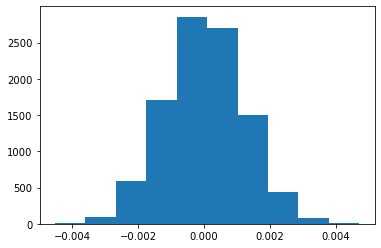

In [26]:
new_converted_simulation = np.random.binomial(n_new.count(), p_new, 10000)/n_new.count()
old_converted_simulation = np.random.binomial(n_old.count(), p_old, 10000)/n_old.count()
p_diffs = np.array(new_converted_simulation - old_converted_simulation)
new_converted_simulation.mean(), old_converted_simulation.mean()
plt.hist(p_diffs)

>Note: In the sample bootstrapping I used sample of size **15000**, since the default data size is enormously huge with **10000** iteration and takes long time to run.

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

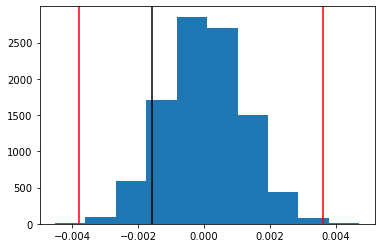

In [27]:
lower, upper = np.percentile(p_diffs, 0.1), np.percentile(p_diffs, 99.9)
plt.hist(p_diffs)
plt.axvline(x=lower, color='red')
plt.axvline(x=upper, color='red')
plt.axvline(x=obs_diff, color='black')

**Yes, according to the Central Limit Theorem with large enough sample size the sample diffrence in means follows the normal distribution. Also, with 99.9% Confidence Interval, most data points fall within the region between the red lines.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > obs_diff).mean()

0.91

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Our statistic appears to come from this distribution above.**

Since the alternative hypothesis is when $p_{new} > p_{old}$, the probability that our observed statistic comes from this distribution is the shading from this statistic (BLACK) line to the right. That is less than half of the distribution, suggesting that our statistic falls within this range between the black and the right red lines. So, the p_value we've computed doesn't support our null hypothesis that is suggesting the alternative that the **new page** is better than the old one.

**The value we've just computed is called $p_{value}$.**

That is with significance level of **$\alpha=0.05$**:
1. If $p_{value} <= \alpha$ (small) we have strong evidence againest null hypothesis (reject $H_{0}$).
2. If $p_{value} > \alpha$ (large) we have weak evidence againest null hypothesis (fail to reject $H_{0}$).

Since, the $p_{value} > 0.05$ is large, so we do not have statistically significent evidence againest the null. Thus, we **fail to reject the $H_{0}$**.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
stat, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old,n_new], alternative='smaller')
stat, pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**$P_{val}$** It's a probability of our observation statistic, or a value with greater evidence againest the null hypothesis, if the $H_{0}$ is actually **true**. And here it matched our earlier calculated value suggests that conversions from the **old page** are statistically better than the **new page**.

**$Z_{score}$** It's a number of standard deviations by which the observed value of a score is above or below the mean value.

And both are statistical significence that help us to decide whether or not to reject the null hypothesis $H_{0}$.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression** should be used since we wanna predict one of two possible outcomes (convert or not) depending on the page (new or old). 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2.landing_page)
df2[['control', 'ab_page']] = pd.get_dummies(df2.group)
df2.drop(['new_page','control'], inplace=True, axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Sep 2020   Pseudo R-squ.:               8.077e-06
Time:                        00:41:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [34]:
1/np.exp(-0.0150)

1.015113064615719

The new page is 1.015 times **less** likely a user to convert with all other holding constant.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**In regression, the $p_{val}$ is given for testing if a parameter is equal to 0 (null $H_{0})$ or doesn't (alternative $H_{1}$).**

**$H_{0}: parameter = 0$**

**$H_{1}: parameter \not= 0$**

**$p_{val}$ for old page: 0.0**

Seems to be statistically significant in relating to the response variable.

**$p_{val}$ for new page (ab_page): 0.19**

Seems to be not statistically significant in relating to the response variable.

These $p_{values}$ differs, since the regression is **two-tailed** test. While in **Part II** the $p_{val}$ the null hypothesis states that the **old page** is better than or equal to the new one and it's **one-talied** test. Thus, the $p_{values}$ have a different meaning.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There're other factors may affect our model such as:**
1. **Change Aversion:** It gives a short-term negative reaction to the **control group** to the changes in the **old_page**, users might be unhappy.
2. **Novelty Effect:** It gives a short-term negative reaction to the **treatment** group to the changes in the **new_page**, users may be clicking around in need to see how it works which gives false positives.

Since these effects are temporary, and to avoid these effects it's recommended to run the new test change for at least 4 weeks.

**The disadvantages regarding adding additional terms into our regression model:**
1. **Collinearity:** We want to our predictor variable (x) to be correlated with our response (y), not to other variables, so we can address this by using **scatterplot matrix** to see the correlations between our variables or **Variance Inflation Factor (VIF)**. If we found a large **VIF > 10**, then we have collinearity with our model.
2. **Higher Order Terms:**  We want to better predict our response when our predictor (x) is not linearly related with the response (y). But adding higher-order terms like (interactions, quadratics, and cubics) without seeing the relationship in the data makes interpreting the results more complex.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
df_countries = pd.read_csv('countries.csv')
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [36]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new.country)
df_new.drop('US', axis=1, inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,CA,UK
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1


In [37]:
final_mod = sm.Logit(df_new.converted, df_new[['intercept', 'CA', 'UK']])
final_res = final_mod.fit()
final_res.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Sep 2020   Pseudo R-squ.:               1.521e-05
Time:                        00:41:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [38]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

Compared to **US** overall conversions:
1. **CA:** is 1.04 **less** likely to convert to the **new page**.
2. **UK:** is 1.01 **more** likely to convert to the **new page**.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
df_new['CA_new_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_new_page'] = df_new['UK']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,CA,UK,CA_new_page,UK_new_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1


In [40]:
final_mod2 = sm.Logit(df_new.converted, df_new[['intercept', 'CA_new_page', 'UK_new_page']])
final_res2 = final_mod2.fit()
final_res2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Sep 2020   Pseudo R-squ.:               2.364e-05
Time:                        00:42:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_new_page    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_new_page     0.0149      0.017      0.862      0.389      -0.019       0.049
===============================================================================
"""

In [41]:
1/np.exp(-0.0752), np.exp(0.0149)

(1.0780997492739288, 1.0150115583846535)

For the treatment group who recieved the new page and compared to **US** conversions:
1. **CA:** is 1.08 **less** likely to convert to the **new page**.
2. **UK:** is 1.02 **more** likely to convert to the **new page**.

Eventually, overall **CA** conversions are lower for the new page, and in **UK** overall conversions are higher for the new page. So, maybe **CA** suffers more from **change aversion** and **UK** gives false positives **(novelty effect)**. However, these changes are slightly small.

<a id='conclusions'></a>
## Conclusion

In this report, we've analyzed A/B tests results which is common used in the real world senarios with:
- **Part I:** Understanding the dataset, dealing with messy data, and calculating the conversion probabilities for each group **(control and treatment)**.
- **Part II:** Conducting hypothesis testing with propostion of conversions **(conversion rate)** in the new page as well as in the old one, performing sampling distribution with bootstrapping in order to simulate the results with **Central Linit Theorem**, and calculating the $P_{val}$ over Type I error rate $\alpha = 0.05$ to decide whether to reject the $H_{0}$ or accept $H_{1}$.
- **Part III:** Applying a logistic regression model with three different countries in order to predict whether a user of a specific country will convert to the **new page** or stick in the old one.

## Resources

1. [Validity Threats That Will Make Your A/B Tests Useless](https://splitbase.com/blog/ab-testing-threats)
2. [Why User Hate What You Launched (Change Aversion)](https://medium.com/m/global-identity?redirectUrl=https%3A%2F%2Flibrary.gv.com%2Fchange-aversion-why-users-hate-what-you-launched-and-what-to-do-about-it-2fb94ce65766)
4. [The Difference Between One-Taild and Two-Tailed](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/)
3. [Z-Score](https://www.statisticshowto.com/probability-and-statistics/z-score/)
